## 🌐 **Google Drive Connection**

In [94]:
# Install and configure Kaggle API
!pip install -q kaggle

from google.colab import files
print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")
files.upload()  # select kaggle.json from your pc, using the API from user->setting in KAGGLE (create new token)

# Configura le credenziali
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Monta Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

# Percorso di destinazione sul Drive
dataset_path = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
!mkdir -p {dataset_path}

# Scarica il dataset direttamente da Kaggle nella cartella scelta
!kaggle competitions download -c an2dl2526c1 -p {dataset_path}

# Decomprimi (opzionale, solo se i file sono .zip)
!unzip -o {dataset_path}/an2dl2526c1.zip -d {dataset_path}

print(f"Dataset scaricato e disponibile in: {dataset_path}")


Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)


Saving kaggle.json to kaggle.json
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
an2dl2526c1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/an2dl2526c1.zip
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_test.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train_labels.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/sample_submission.csv  
Dataset scaricato e disponibile in: /content/gdrive/MyDrive/Artificial_Neural_Net

## ⚙️ **Libraries Import**

In [95]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [96]:
dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
os.makedirs(dataset_path, exist_ok=True)

competition = "an2dl2526c1"
# file needed
dataset_files = ["pirate_pain_test.csv", "pirate_pain_train.csv", "pirate_pain_train_labels.csv"]

# Download file if not done yet
for fname in dataset_files:
    dest_path = os.path.join(dataset_path, fname)
    if not os.path.exists(dest_path):
        print(f"📥 Downloading {fname} ...")
        !kaggle competitions download -c {competition} -f {fname} -p {dataset_path}
    else:
        print(f"✅ {fname} already exists. Using cached version.")

print("\nAll files ready in:", dataset_path)


✅ pirate_pain_test.csv already exists. Using cached version.
✅ pirate_pain_train.csv already exists. Using cached version.
✅ pirate_pain_train_labels.csv already exists. Using cached version.

All files ready in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


In [97]:
df_training = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train.csv"))
df_labels = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train_labels.csv"))
df_test = pd.read_csv(os.path.join(dataset_path, "pirate_pain_test.csv"))

# create a single dataset with the labels associated
df_training = df_training.merge(df_labels, on='sample_index', how='left')

## 🔎 **Data exploration**

In [ ]:
# @title Profiling
#data_profile = ProfileReport(df_train, title="Profiling Report")
#data_profile

In [98]:
# @title Data type conversions
# Convert joint columns
joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
for col in joint_cols:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce').astype('float32')

# Convert survey values
survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
for col in survey_cols:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce').astype('int8')

# Creation of unique injury related feature
df_training['is_injured'] = (df_training['n_legs'] != 'two').astype('int8')

# Drop columns
cols_to_drop = [
    'joint_30',   #constant
    'n_eyes', 'n_hands', 'n_legs' #redundant
]
df_training = df_training.drop(columns=[c for c in cols_to_drop if c in df_training.columns])

#df_training.info()

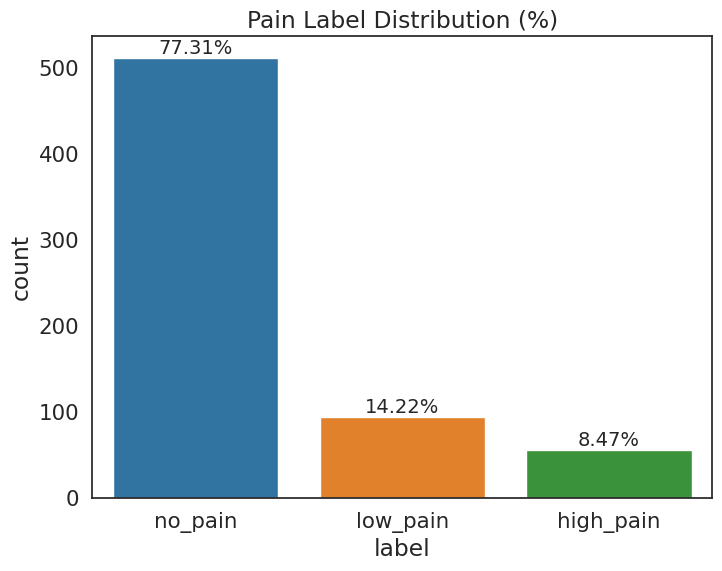

In [ ]:
# @title Class distribution
plt.figure(figsize=(8,6))
sns.countplot(
    data=df_labels,
    x='label',
    order=df_labels['label'].value_counts().index,
    palette='tab10'
)

counts = df_labels['label'].value_counts()
perc = (counts / len(df_labels) * 100).round(2)

for i, (cls, pct) in enumerate(perc.items()):
    plt.text(i, counts[i], f"{pct}%", ha='center', va='bottom')

plt.title("Pain Label Distribution (%)")
plt.show()


****

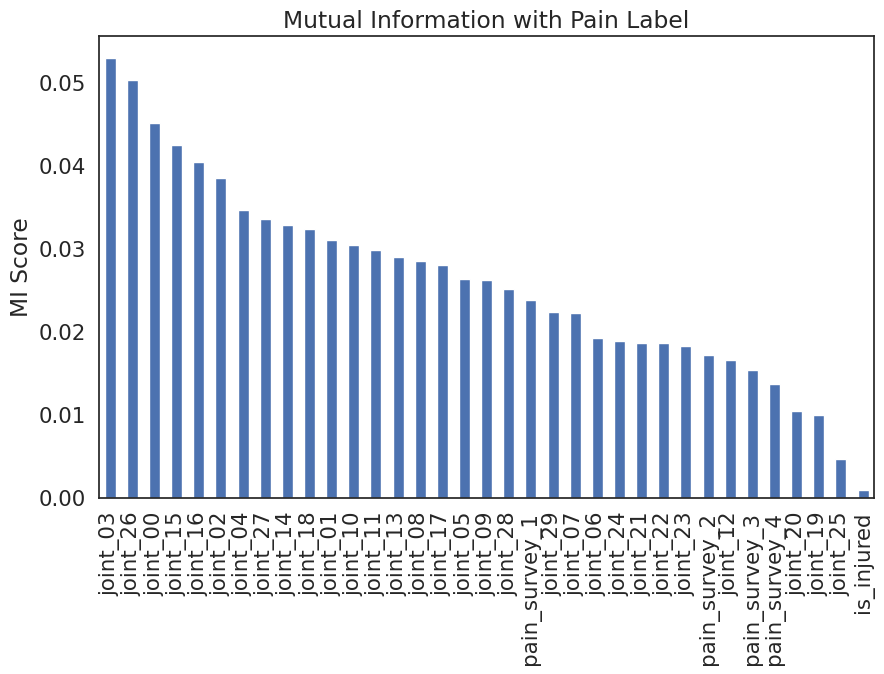

In [ ]:
#@title Mutual Information with pain Label

df_mi = df_training.copy()
df_mi['label'] = df_mi['label'].astype('category').cat.codes

joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
survey_cols = ['pain_survey_1','pain_survey_2','pain_survey_3','pain_survey_4']
injury_cols = ['is_injured']
X = df_mi[joint_cols + survey_cols + injury_cols]
y = df_mi['label']

mi_scores = mutual_info_classif(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
mi_series.plot(kind='bar')
plt.title("Mutual Information with Pain Label")
plt.ylabel("MI Score")
plt.show()


**Outliers detection**

In [ ]:
#@title Plot joints mean over time
# Select joint features
joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
joint_cols = sorted(joint_cols, key=lambda x: int(x.split("_")[1]))

# Ensure time is sorted
df_sorted = df_training.sort_values("time")

# Classes present
classes = ['no_pain', 'low_pain', 'high_pain']
colors = ['blue', 'orange', 'green']

# Loop through all joint features
for (i,col) in enumerate(joint_cols):
    plt.figure(figsize=(12, 4))

    for cls, color in zip(classes, colors):
        # Select only rows of this class
        df_cls = df_sorted[df_sorted['label'] == cls]

        # Compute mean aggregation by time
        mean_ts = df_cls.groupby("time")[col].mean()

        plt.plot(mean_ts.index, mean_ts.values, label=cls, color=color)

    plt.title(f"Time progression mean per class — {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/media_plot{i}.png", dpi=300, bbox_inches="tight")
    plt.show()


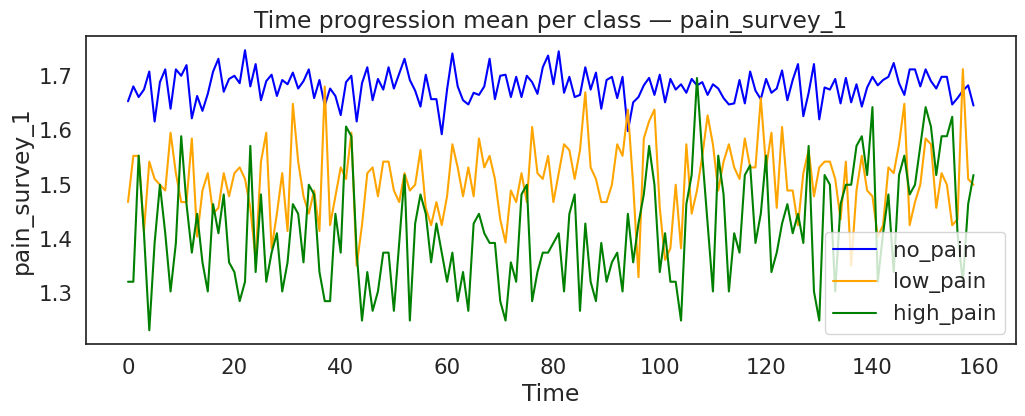

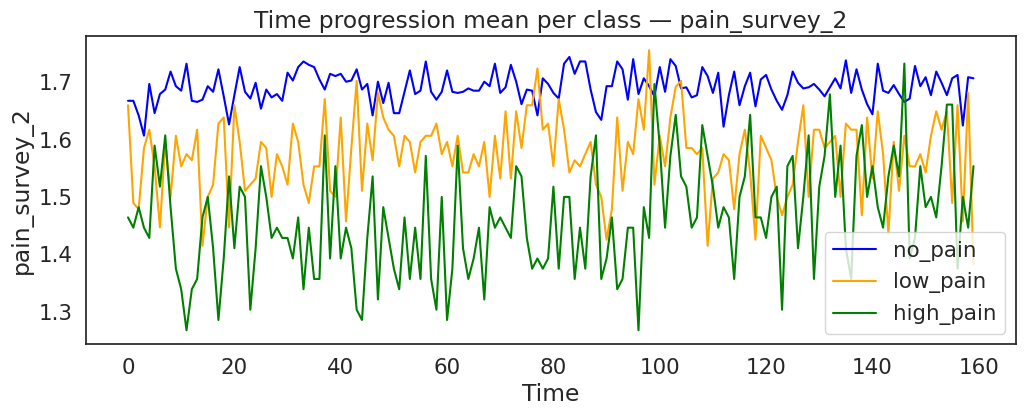

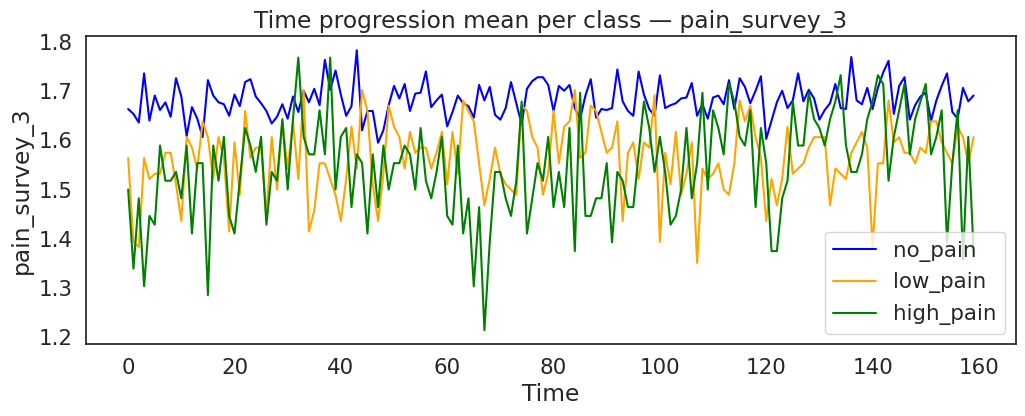

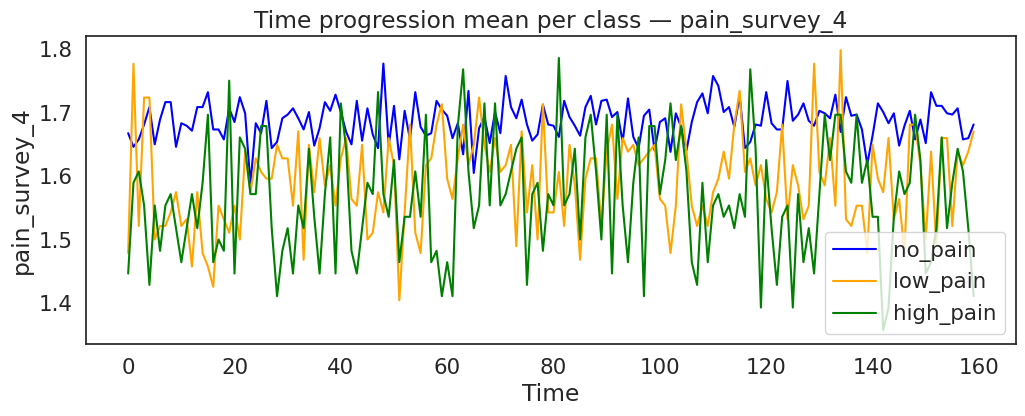

In [ ]:
# @title Plot surveys mean over time
# Select survey features
survey_cols = [col for col in df_training.columns if col.startswith("pain_survey_")]

# Ensure time ordering
df_sorted = df_training.sort_values("time")

# Labels and colors
classes = ['no_pain', 'low_pain', 'high_pain']
colors = ['blue', 'orange', 'green']

# Loop over surveys
for col in survey_cols:
    plt.figure(figsize=(12, 4))

    for cls, color in zip(classes, colors):
        df_cls = df_sorted[df_sorted['label'] == cls]

        # Compute mean per time
        mean_ts = df_cls.groupby("time")[col].mean()

        plt.plot(mean_ts.index, mean_ts.values, label=cls, color=color)

    plt.title(f"Time progression mean per class — {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [99]:
# Label mapping
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
df_training['label'] = df_training['label'].map(label_mapping)

# df_training.info()

#🧽 **Data cleaning and normalization**

In [100]:
# @title Min-Max scaling
def minmax_scaling(df_train, df_val):

    # Continuous columns
    survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
    joint_cols = [col for col in df_train.columns if col.startswith('joint_')]
    continuous_cols = survey_cols + joint_cols

    # Local copies
    df_train_scaled = df_train.copy()
    df_val_scaled = df_val.copy()

    # Avoid data leakage
    mins = df_train_scaled[continuous_cols].min()
    maxs = df_train_scaled[continuous_cols].max()

    # Avoid division by 0
    ranges = maxs - mins
    ranges = ranges.replace(0, 1)

    # Scaling
    df_train_scaled[continuous_cols] = (df_train_scaled[continuous_cols] - mins) / ranges
    df_val_scaled[continuous_cols] = (df_val_scaled[continuous_cols] - mins) / ranges

    return df_train_scaled, df_val_scaled


#⚙️ **Hyperparameters**

In [267]:
# ============================================
# Architecture
# ============================================
RNN_TYPE = 'GRU'
BIDIRECTIONAL = False
HIDDEN_LAYERS = 2
HIDDEN_SIZE = 128
DROPOUT_RATE = 0.3


# ============================================
# Testa MLP
#  → biGRU: 2 * 128 = 256 input
#  → 256 → 128 → 64 → 3
# ============================================
MLP_HIDDEN = [128]
MLP_DROPOUT = [0.3]


# ============================================
# Training
# ============================================
BATCH_SIZE = 32
EPOCHS = 500
PATIENCE = 50
LEARNING_RATE = 1e-3


# ============================================
# Regularization
# ============================================
L1_LAMBDA = 0.00
L2_LAMBDA = 0.0025

T_NO_PAIN = 0.60
T_LOW_PAIN = 0.45
T_HIGH_PAIN = 0.40


# ============================================
# Windowing
# ============================================
WINDOW_SIZE = 20
STRIDE = 10


In [268]:
def compute_class_weights(df, label_col="label"):
    class_counts = df[label_col].value_counts().sort_index().values
    w = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float32))
    w[2] *= 1.2   # boost per high_pain
    return w


#➗ **Train-Validation split**

In [269]:
from sklearn.model_selection import train_test_split

# Pirate-wise splitting
df_subjects = (
    df_training[['sample_index', 'label']]
    .drop_duplicates(subset=['sample_index'])
)

# Stratified Train/Validation split
train_subjects, val_subjects = train_test_split(
    df_subjects['sample_index'],
    test_size=0.2,
    random_state=SEED,
    stratify=df_subjects['label']
)

# Dataset split
df_train = df_training[df_training['sample_index'].isin(train_subjects)].copy()
df_val = df_training[df_training['sample_index'].isin(val_subjects)].copy()

In [270]:
# # 1) Pirati per classe nel training
# train_pirates = (
#     df_train[['sample_index', 'label']]
#     .drop_duplicates()
# )

# print("Pirati per classe (prima undersampling):")
# print(train_pirates['label'].value_counts())

# # 2) Separiamo no_pain vs altre classi
# no_pain_ids = train_pirates[train_pirates['label'] == 0]['sample_index'].values
# other_ids   = train_pirates[train_pirates['label'] != 0]['sample_index'].values

# # 3) Scegli quanti pirati no_pain vuoi tenere
# TARGET_NO_PAIN = 400

# if len(no_pain_ids) > TARGET_NO_PAIN:
#     kept_no_pain_ids = np.random.choice(
#         no_pain_ids,
#         size=TARGET_NO_PAIN,
#         replace=False
#     )
# else:
#     kept_no_pain_ids = no_pain_ids  # se sono già pochi, lasciali tutti

# # 4) Nuova lista di pirati da tenere
# kept_ids = np.concatenate([kept_no_pain_ids, other_ids])

# # 5) Ricostruisci df_train ridotto
# df_train = df_train[df_train['sample_index'].isin(kept_ids)].reset_index(drop=True)

# print("\nPirati per classe (DOPO undersampling casuale):")
# print(
#     df_train[['sample_index', 'label']]
#     .drop_duplicates()['label']
#     .value_counts()
# )


In [271]:
# Min-Max scaling
df_train, df_val = minmax_scaling(df_train, df_val)
df_train = df_train.fillna(0.0)
df_val = df_val.fillna(0.0)

# Weighted loss function
class_weights = compute_class_weights(df_train)

In [272]:
# Datset split integrity checks
# print(f"Train pirates and rows: {len(train_subjects)}, {len(df_train)}")
# print(f"Val pirates and rows: {len(val_subjects)}, {len(df_val)}")

# print("\nDistribution")
# print("Training:")
# train_props = df_train[['sample_index','label']].drop_duplicates()['label'].value_counts(normalize=True)
# for cls, p in train_props.items():
#     print(f"\t{cls}: {p:.4f}")

# print("Validation:")
# val_props = df_val[['sample_index','label']].drop_duplicates()['label'].value_counts(normalize=True)
# for cls, p in val_props.items():
#     print(f"\t{cls}: {p:.4f}")

#🪟 **Sequence building**

In [273]:
# joint_cols = [c for c in df_train.columns if c.startswith("joint_")]
# survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
# feature_cols = joint_cols + survey_cols + ["is_injured"]

# === 1) LISTA DELLE FEATURE SCELTE ===
selected_features = [
    "joint_00",
    "joint_01",
    "joint_02",
    "joint_03",

    "joint_04",
    "joint_05",

    "joint_06",
    "joint_07",
    "joint_08",
    "joint_09",

    "joint_10",
    "joint_12",

    "joint_26",
    "joint_27",
    "joint_28",
    "joint_29",

    "pain_survey_1",
    "pain_survey_2",
    "pain_survey_3"
]

feature_cols = selected_features

def build_windows(df, window=40, stride=20):

    df = df.copy()

    for col in survey_cols:
        if df[col].dtype.name == "category":
            df[col] = df[col].cat.codes

    # if df["is_injured"].dtype.name == "category":
    #     df["is_injured"] = df["is_injured"].cat.codes

    # assert window % stride == 0

    X_windows = []
    y_windows = []

    for sid, group in df.groupby('sample_index'):

        # Sort by time series order
        group = group.sort_values("time")

        # Extract features
        X = group[feature_cols].values.astype('float32')

        # Label per pirate
        y = group['label'].iloc[0]

        # Padding
        padding_len = (window - len(X) % window) % window
        if padding_len > 0:
            X = np.concatenate(
                [X, np.zeros((padding_len, X.shape[1]), dtype='float32')]
            )

        # Generate windows
        for start in range(0, len(X) - window + 1, stride):
            X_windows.append(X[start:start+window])
            y_windows.append(y)

    return np.array(X_windows, dtype=np.float32), np.array(y_windows, dtype=np.int64)


In [274]:
# Build windows
X_train, y_train = build_windows(df_train, WINDOW_SIZE, STRIDE)
X_val, y_val = build_windows(df_val, WINDOW_SIZE, STRIDE)

# === OVERSAMPLING HIHG PAIN ===#

# # Oversampling high_pain
# high_class = 2
# X_high = X_train[y_train == high_class]
# y_high = y_train[y_train == high_class]

# X_train = np.concatenate([X_train] + [X_high] * REPEAT, axis=0)
# y_train = np.concatenate([y_train] + [y_high] * REPEAT, axis=0)

# # #Shuffle after oversampling
# shuffle_idx = np.random.permutation(len(X_train))
# X_train = X_train[shuffle_idx]
# y_train = y_train[shuffle_idx]

# === OVERSAMPLING HIHG PAIN ===#

# Print the shapes of the generated datasets and their labels
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)

# Define input shape for the RNN
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

X_train: (7920, 20, 19) y_train: (7920,)
X_val:   (1995, 20, 19) y_val:   (1995,)


In [275]:
# Convert to PyTorch datasets
train_ds = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train)
)

val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val)
)

In [276]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [277]:
train_loader = make_loader(train_ds, BATCH_SIZE, True,  False)
val_loader   = make_loader(val_ds,   BATCH_SIZE, False, False)

In [278]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([32, 20, 19])
Labels batch shape: torch.Size([32])


# 🛠️ **Model Building**

In [279]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [280]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        # self.classifier = nn.Linear(classifier_input_size, num_classes)
        # ===== HEAD MLP PARAMETRICA =====
        layers = []
        in_dim = classifier_input_size

        for hdim, dr in zip(MLP_HIDDEN, MLP_DROPOUT):
            layers.append(nn.Linear(in_dim, hdim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dr))
            in_dim = hdim

        # ultimo layer verso le classi
        layers.append(nn.Linear(in_dim, num_classes))

        self.classifier = nn.Sequential(*layers)
        # =================================



    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 20, 128], [2, -1, 128]] 52,096         
Total params: 52,096
Trainable params: 52,096
Non-trainable params: 0
-------------------------------------------------------------------------------


In [281]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 **Model Training**

In [282]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [283]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [284]:
import torch.nn.functional as F

def threshold_predict(logits,
                      t_no_pain=T_NO_PAIN,
                      t_low_pain=T_LOW_PAIN,
                      t_high_pain=T_HIGH_PAIN):
    """
    logits: tensor (batch, 3)
    Ritorna: predizioni (tensor) shape (batch,)
    """

    probs = F.softmax(logits, dim=1)

    NO = 0
    LOW = 1
    HIGH = 2

    preds = []

    for p in probs:
        if p[NO] >= t_no_pain:
            preds.append(NO)
            continue
        if p[LOW] >= t_low_pain:
            preds.append(LOW)
            continue
        if p[HIGH] >= t_high_pain:
            preds.append(HIGH)
            continue

        preds.append(torch.argmax(p).item())

    return torch.tensor(preds)


In [285]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)

            #===THRESHOLD===#
            #predictions = logits.argmax(dim=1)
            predictions = threshold_predict(logits)
            #===THRESHOLD===#

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [286]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [287]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

#⚠️ **MODEL**

In [288]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "rnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)


# ----------------------------
# OPTIMIZER & MIXED PRECISION
# ----------------------------

# Define optimizer
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#criterion = nn.CrossEntropyLoss()

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 20, 128], [2, -1, 128]] 156,288        
Total params: 156,288
Trainable params: 156,288
Non-trainable params: 0
-------------------------------------------------------------------------------


In [289]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name="rnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.8770, F1 Score=0.7400 | Val: Loss=0.8898, F1 Score=0.7122
Epoch  10/500 | Train: Loss=0.2921, F1 Score=0.9275 | Val: Loss=0.6728, F1 Score=0.8026
Epoch  20/500 | Train: Loss=0.1476, F1 Score=0.9608 | Val: Loss=0.4608, F1 Score=0.8985
Epoch  30/500 | Train: Loss=0.0994, F1 Score=0.9704 | Val: Loss=0.6084, F1 Score=0.8744
Epoch  40/500 | Train: Loss=0.0801, F1 Score=0.9755 | Val: Loss=0.5415, F1 Score=0.9081
Epoch  50/500 | Train: Loss=0.1013, F1 Score=0.9699 | Val: Loss=0.5419, F1 Score=0.9180
Epoch  60/500 | Train: Loss=0.0620, F1 Score=0.9825 | Val: Loss=0.4846, F1 Score=0.9190
Epoch  70/500 | Train: Loss=0.0621, F1 Score=0.9800 | Val: Loss=0.5904, F1 Score=0.9099
Epoch  80/500 | Train: Loss=0.0517, F1 Score=0.9836 | Val: Loss=0.5747, F1 Score=0.9204
Epoch  90/500 | Train: Loss=0.0415, F1 Score=0.9841 | Val: Loss=0.7826, F1 Score=0.9003
Epoch 100/500 | Train: Loss=0.0392, F1 Score=0.9886 | Val: Loss=0.5300, F1 Score=0.9207
Epoch 110

#📈 **Results**

In [290]:
def evaluate_final(model, val_loader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(xb)

            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    # Concatenate all batches
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)

    # Compute metrics
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # FP and FN
    FP = cm.sum(axis=0) - np.diag(cm)   # predetti come classe i ma non erano classe i
    FN = cm.sum(axis=1) - np.diag(cm)   # erano classe i ma predetti altra classe

    print("=== FINAL VALIDATION PERFORMANCE ===")
    print(f"F1 Weighted: {f1_weighted:.4f}")
    print(f"F1 Macro:    {f1_macro:.4f}")
    print(f"F1 Per Class (0=no_pain, 1=low_pain, 2=high_pain): {f1_per_class}")

    print("\nConfusion Matrix:")
    print(cm)

    print("\nFalse Positives per class:")
    print(f"0=no_pain:   {FP[0]}")
    print(f"1=low_pain:  {FP[1]}")
    print(f"2=high_pain: {FP[2]}")

    print("\nFalse Negatives per class:")
    print(f"0=no_pain:   {FN[0]}")
    print(f"1=low_pain:  {FN[1]}")
    print(f"2=high_pain: {FN[2]}")

    return f1_weighted, f1_macro, f1_per_class, cm, FP, FN

evaluate_final(best_model, val_loader, device)

=== FINAL VALIDATION PERFORMANCE ===
F1 Weighted: 0.9366
F1 Macro:    0.8627
F1 Per Class (0=no_pain, 1=low_pain, 2=high_pain): [0.9648727  0.91592129 0.70731707]

Confusion Matrix:
[[1497   18   30]
 [  12  256   17]
 [  49    0  116]]

False Positives per class:
0=no_pain:   61
1=low_pain:  18
2=high_pain: 47

False Negatives per class:
0=no_pain:   48
1=low_pain:  29
2=high_pain: 49


(0.9365780509184571,
 0.8627036883400138,
 array([0.9648727 , 0.91592129, 0.70731707]),
 array([[1497,   18,   30],
        [  12,  256,   17],
        [  49,    0,  116]]),
 array([61, 18, 47]),
 array([48, 29, 49]))

Accuracy over the validation set: 0.9368
Precision over the validation set: 0.9364
Recall over the validation set: 0.9368
F1 score over the validation set: 0.9366


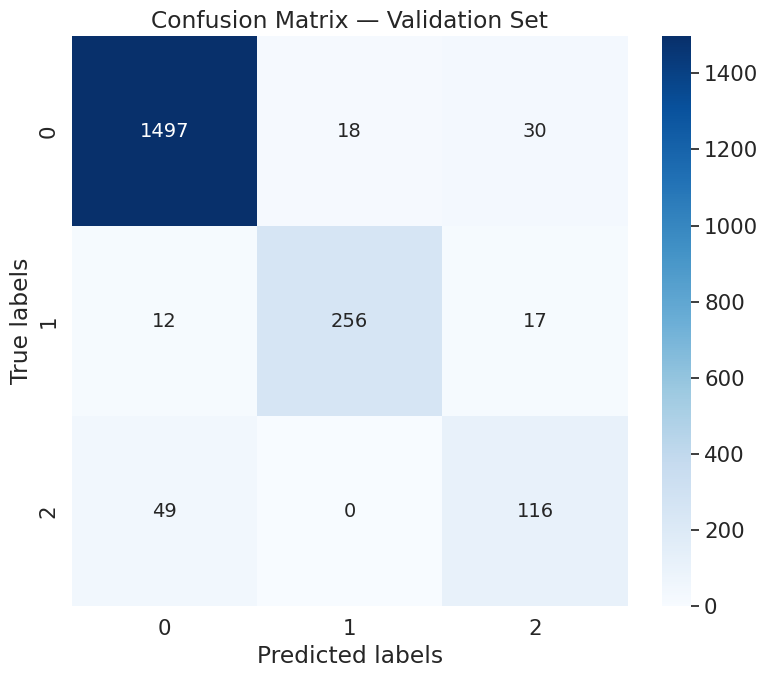

In [291]:
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

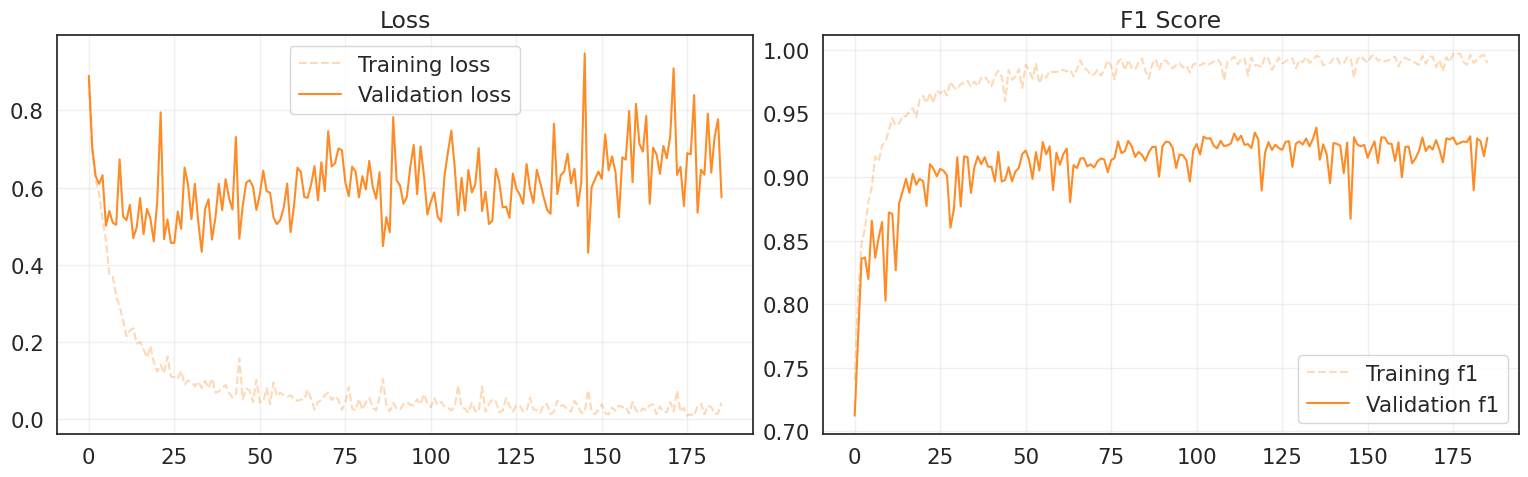

In [292]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

#🔗 **Save the model!**

In [293]:
# Create a local directory
save_dir = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models"
os.makedirs(save_dir, exist_ok=True)

# File name
MODEL_PATH = os.path.join(save_dir, "best_model.pth")

# Store the weights
torch.save(best_model.state_dict(), MODEL_PATH)

print(f"Modello salvato localmente in: {MODEL_PATH}")
!ls -lh "$save_dir"

Modello salvato localmente in: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/best_model.pth
total 697K
-rw------- 1 root root 680K Nov 16 17:17 best_model.pth
-rw------- 1 root root  17K Nov 16 02:16 submission.csv


#⚠️ **Kaggle inference**

In [296]:
# Load test
df_test = pd.read_csv(os.path.join(dataset_path, "pirate_pain_test.csv"))

# Ensure dtype identical to training
for col in joint_cols:
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce').astype('float32')

for col in survey_cols:
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce').astype('int8')

df_test["is_injured"] = (df_test["n_legs"] != "two").astype("int8")

# Align all columns to training dataframe
missing_cols = [c for c in df_train.columns if c not in df_test.columns]
for c in missing_cols:
    df_test[c] = 0

df_test = df_test[df_train.columns]   # SAME ORDER

# Scale (training scaler reused, as intended)
df_train_scaled, df_test_scaled = minmax_scaling(df_train, df_test)

df_test = df_test_scaled.fillna(0.0)


In [297]:
def build_windows_test(df, window=WINDOW_SIZE, stride=STRIDE):

    feature_cols = [
      "joint_00",
      "joint_01",
      "joint_02",
      "joint_03",

      "joint_04",
      "joint_05",

      "joint_06",
      "joint_07",
      "joint_08",
      "joint_09",

      "joint_10",
      "joint_12",

      "joint_26",
      "joint_27",
      "joint_28",
      "joint_29",

      "pain_survey_1",
      "pain_survey_2",
      "pain_survey_3"
  ]

    X_windows = []
    indices = []

    for sid, g in df.groupby("sample_index"):
        g = g.sort_values("time")
        X = g[feature_cols].values.astype("float32")

        padding_len = (window - len(X) % window) % window
        if padding_len > 0:
            X = np.concatenate([X, np.zeros((padding_len, X.shape[1]), dtype="float32")])

        for start in range(0, len(X) - window + 1, stride):
            X_windows.append(X[start:start+window])
            indices.append(sid)

    return np.array(X_windows), np.array(indices)


X_test, test_indices = build_windows_test(df_test)


In [298]:
# Recreate model and load weights
best_model_path = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/best_model.pth"
model_for_inference = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type= RNN_TYPE
).to(device)

model_for_inference.load_state_dict(torch.load(best_model_path, map_location=device))
model_for_inference.eval()
print("Model loaded for inference.")


Model loaded for inference.


In [299]:
# === INFERENZA CON SOGLIE PERSONALIZZATE === #

test_ds = TensorDataset(torch.from_numpy(X_test))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []

with torch.no_grad():
    for (xb,) in test_loader:
        xb = xb.to(device)

        logits = model_for_inference(xb)

        # USO DELLE SOGLIE
        preds = threshold_predict(logits).cpu().numpy()

        all_preds.append(preds)

all_preds = np.concatenate(all_preds)

# === MAJORITY VOTE PER SAMPLE === #
pred_df = pd.DataFrame({"sample_index": test_indices, "pred": all_preds})
final_preds = (
    pred_df.groupby("sample_index")["pred"]
    .agg(lambda x: np.bincount(x).argmax())
    .reset_index()
)

inv_label_map = {v: k for k, v in label_mapping.items()}
final_preds["label"] = final_preds["pred"].map(inv_label_map)

submission = final_preds.sort_values("sample_index")[["sample_index", "label"]]

submission_path = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/submission.csv"
submission.to_csv(submission_path, index=False)

print("Submission saved at:", submission_path)


Submission saved at: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/submission.csv
